In [1]:
# ! pip install pandas

In [2]:
# pip install -U numpy==1.18.5

In [3]:
#Import Libraries
import tensorflow as tf
import numpy as np #Linear Algebra
import matplotlib.pyplot as plt #Data visualization
import pandas as pd #data manipulation

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

plt.rcParams["font.family"] = "Times New Roman"

import warnings
warnings.filterwarnings('ignore') #Ignore warnings

#Make sure Tensorflow is version 2.0 or higher
print('Tensorflow Version:', tf.__version__)

Tensorflow Version: 2.0.0


/Users/mayank/opt/anaconda3/envs/deep_learning/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  


In [4]:
#Reads in Pollution csv
pollution = pd.read_csv(r"south-korean-pollution-data.csv",
                       parse_dates=['date'],
                       index_col='date')
#Filters for only pm25 values in Jeongnim-Dong City, sorted by date
pollution = pollution[pollution.City == 'Jeongnim-Dong'].pm25.sort_index()
#starts the dataset at 2018 and ends in 2022(due to breaks in data in previous years)
start = pd.to_datetime('2018-01-01')
end = pd.to_datetime('2022-01-01')
pollution = pollution[start:end]
print('SAMPLE OF TIME SERIES DATA:')
print(pollution.head())
print(pollution.shape)

SAMPLE OF TIME SERIES DATA:
date
2018-01-01    72
2018-01-02    95
2018-01-03    57
2018-01-04    70
2018-01-05    88
Name: pm25, dtype: int64
(1458,)


In [5]:
#Checks for and imputes missing dates
a = pd.date_range(start="2018-01-01", end="2022-01-01", freq="D") #continous dates
b = pollution.index #our time series
diff_dates = a.difference(b) # finds what in 'a' is not in 'b'

td = pd.Timedelta(1, "d") #1 day
for date in diff_dates:
    prev_val = pollution[date-td] #takes the previous value
    pollution[date] = prev_val #imputes previous value

pollution.sort_index(inplace=True)
#sets the time index frequency as daily
pollution.freq = "D"

In [6]:
# plt.rcParams['savefig.dpi'] = 300

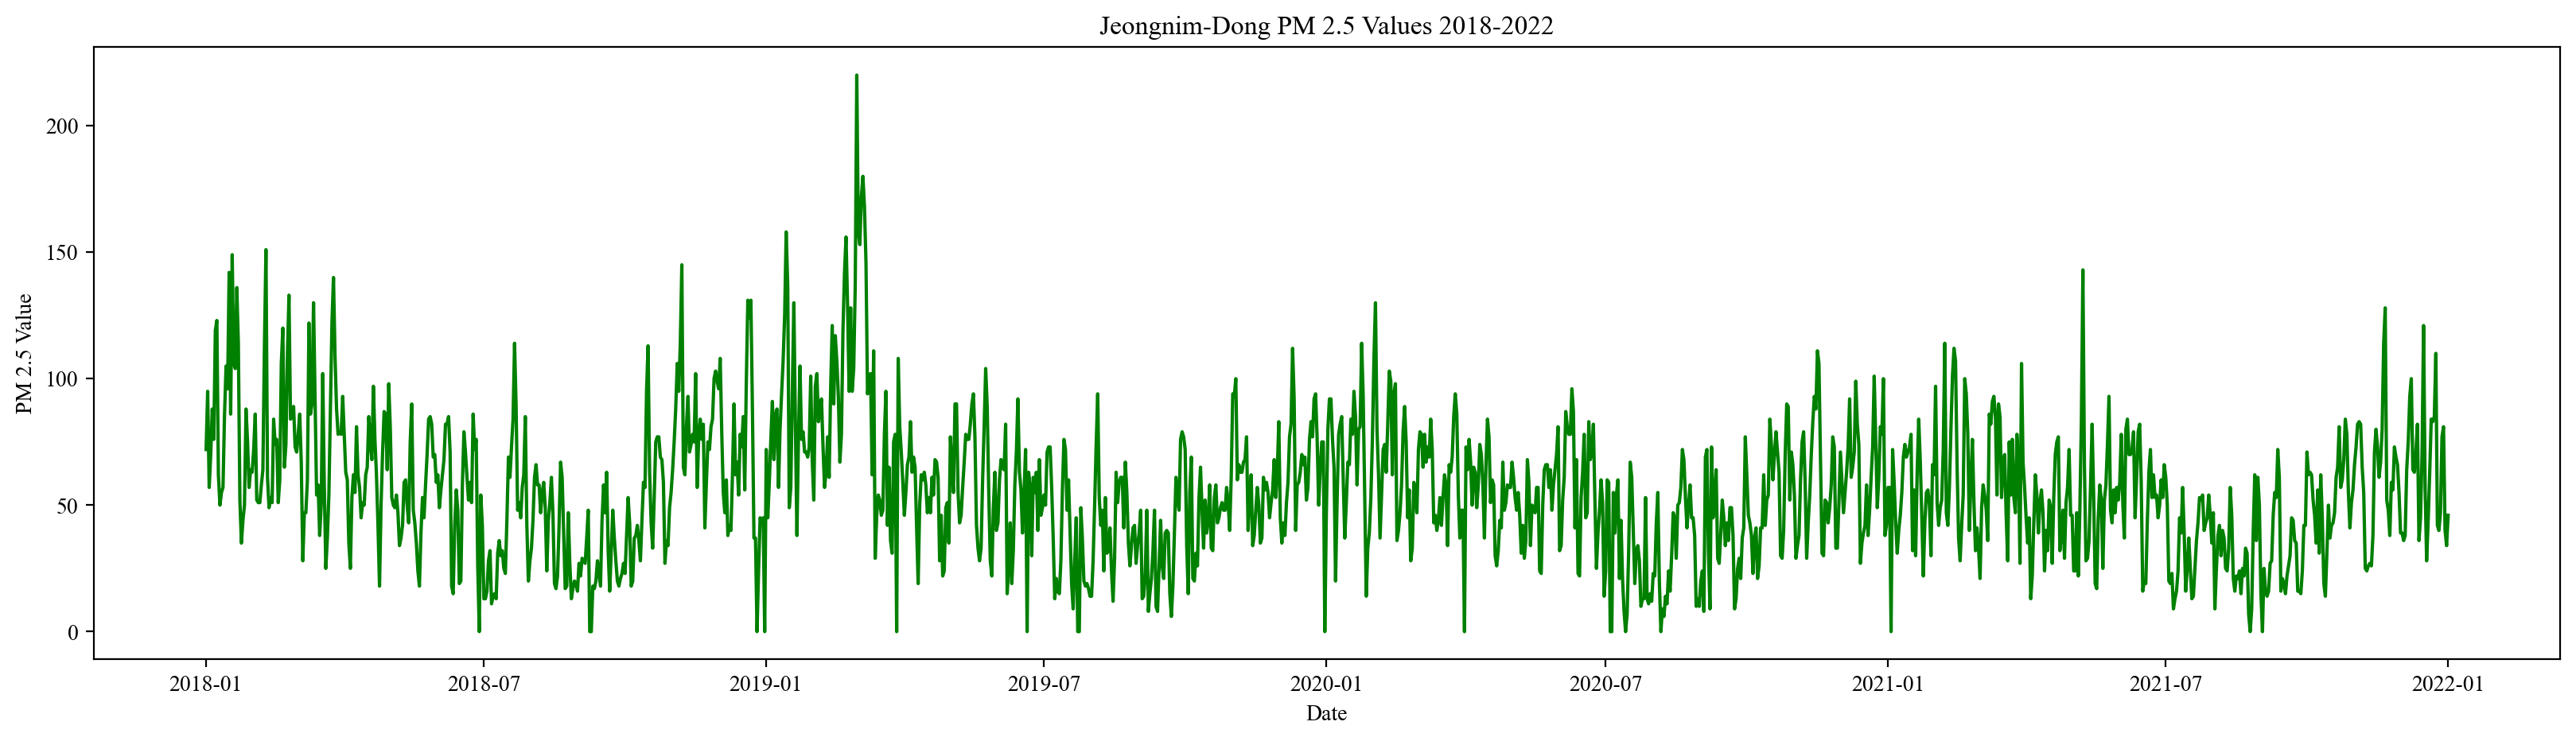

In [7]:
#displays a plot of the pm25 values since 2018
fig = plt.figure(figsize=(20,5))
plt.plot(pollution, color='green')
plt.xlabel('Date')
plt.ylabel('PM 2.5 Value')
plt.title('Jeongnim-Dong PM 2.5 Values 2018-2022')
plt.show()

In [8]:
#Split the time series data into a train and test set
end_train_ix = pd.to_datetime('2020-12-31')
train = pollution[:end_train_ix] # Jan 2018-2021
test = pollution[end_train_ix:] # Jan 2021-2022

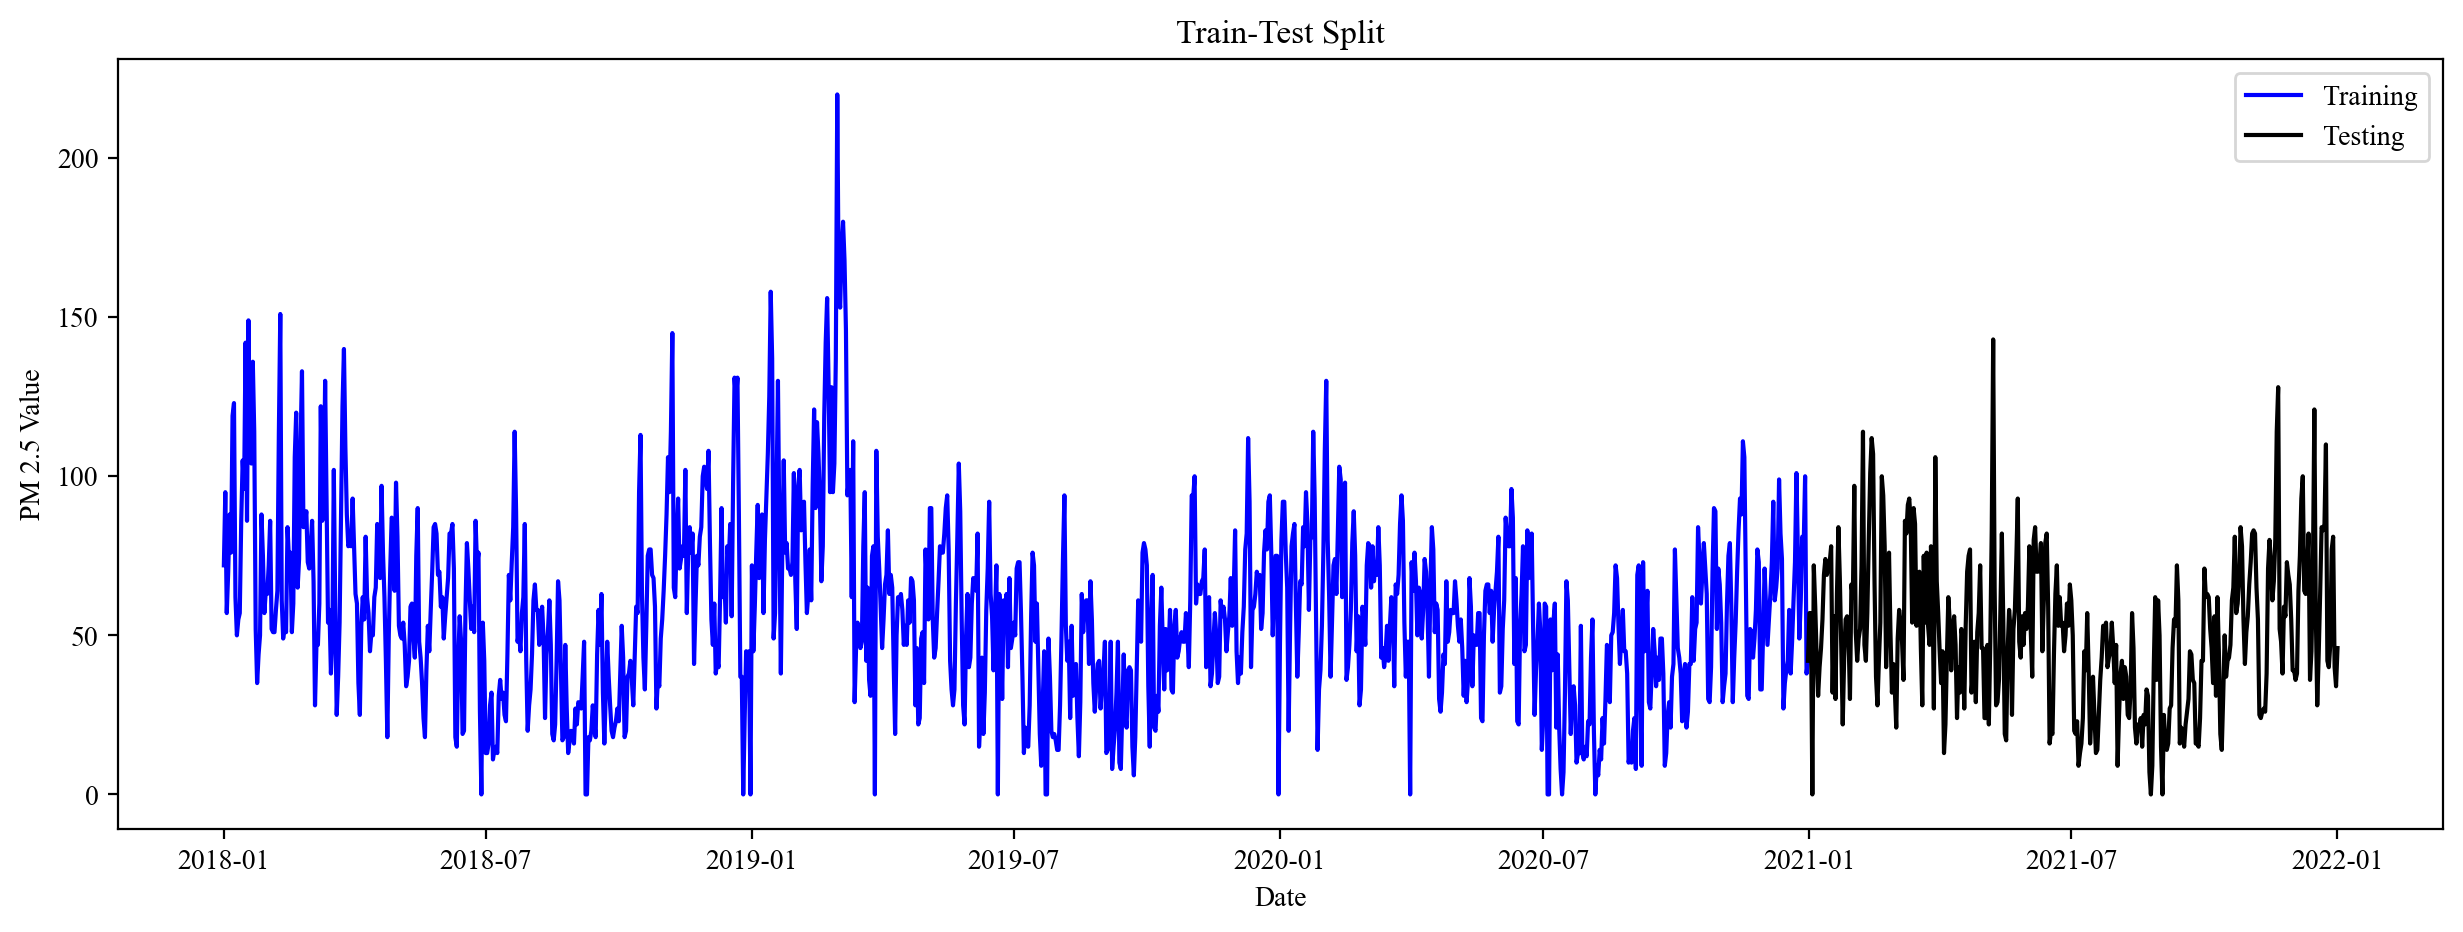

In [9]:
#displays a plot of the train/test split
fig = plt.figure(figsize=(15,5))
plt.plot(train, color='blue', label='Training')
plt.plot(test, color='black', label='Testing')
plt.xlabel('Date')
plt.ylabel('PM 2.5 Value')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [10]:
#Creates a windowed dataset from the time series data
WINDOW = 14 #the window value... 14 days

#converts values to TensorSliceDataset
train_data = tf.data.Dataset.from_tensor_slices(train.values) 

#takes window size + 1 slices of the dataset
train_data = train_data.window(WINDOW+1, shift=1, drop_remainder=True)

#flattens windowed data by batching 
train_data = train_data.flat_map(lambda x: x.batch(WINDOW+1))

#creates features and target tuple
train_data = train_data.map(lambda x: (x[:-1], x[-1]))

#shuffles dataset
train_data = train_data.shuffle(1_000)

#creates batches of windows
train_data = train_data.batch(32).prefetch(1)

2022-11-04 18:08:54.564510: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-04 18:08:54.565084: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 10. Tune using inter_op_parallelism_threads for best performance.


In [11]:
from tensorflow.keras.callbacks import Callback

class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('mae') < 10.0:
            print("MAE under 10.0... Stopping training")
            self.model.stop_training = True

my_callback = CustomCallback()

In [12]:
from tensorflow.keras.callbacks import LearningRateScheduler

#creates a function that updates the learning rate based on the epoch number
def scheduler(epoch, lr):
    if epoch < 2:
        return 0.01
    else:
        return lr * 0.99

lr_scheduler = LearningRateScheduler(scheduler)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Lambda, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber


lstm_model = Sequential([
    # add extra axis to input data
    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[WINDOW]), 
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(128)),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(1)
])

lstm_model.compile(
    loss=Huber(),
    optimizer=Adam(),
    metrics=['mae']
)

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 14, 1)             0         
_________________________________________________________________
bidirectional (Bidirectional (None, 14, 256)           133120    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 593,409
Trainable params: 593,409
Non-trainable params: 0
__________________________________________________

In [14]:
#Trains LSTM Model
lstm_history = lstm_model.fit(
    train_data,
    epochs=100,
    callbacks=[lr_scheduler, my_callback],
    verbose=0
)

2022-11-04 18:10:14.375059: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_9048_9531' and '__inference___backward_standard_lstm_9048_9531_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_11287' both implement 'lstm_f006b8a9-0cd1-43a1-bfd9-f4e5ccf18b7e' but their signatures do not match.
2022-11-04 18:10:23.879784: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-11-04 18:10:31.320761: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-11-04 18:10:38.191095: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End 

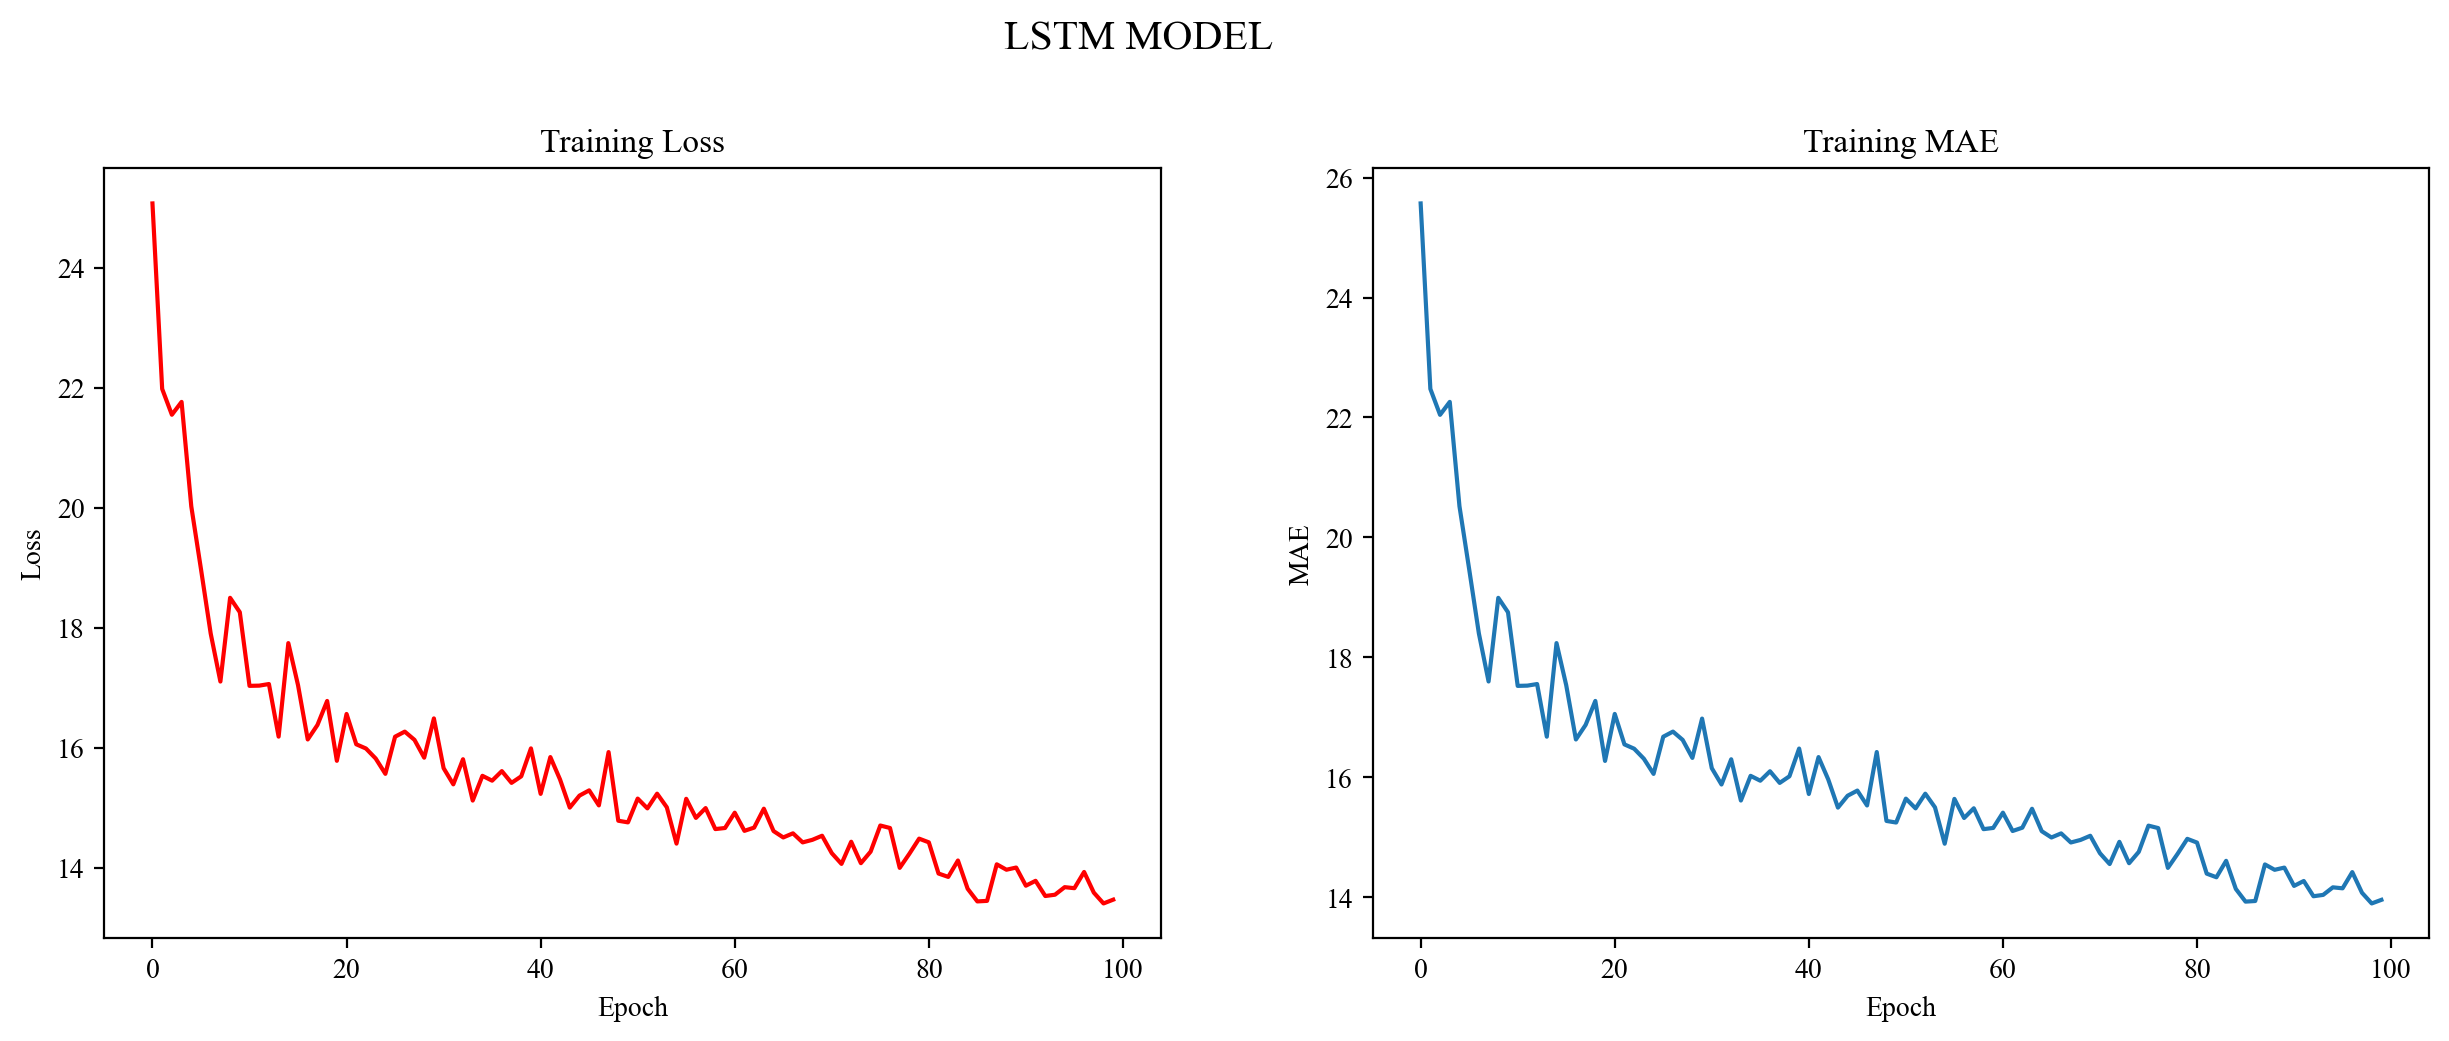

					FINAL LOSS: 13.47 | FINAL MAE: 13.960000038146973


In [18]:
#plots training history
#Plots history of model training
plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1, 2)

axs[0].plot(lstm_history.history['loss'], color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(lstm_history.history['mae'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MAE')
axs[1].set_title('Training MAE')

fig.text(0.425,1, 'LSTM MODEL', {'size':15})
plt.show()

print("\t\t\t\t\tFINAL LOSS: {} | FINAL MAE: {}".format(
                                                round(lstm_history.history['loss'][-1], 2),
                                                 round(lstm_history.history['mae'][-1] ,2)))